.



# Project: European Soccer Database Analysis 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The database contents:

- +25,000 matches
- +10,000 players
- 11 European Countries with their lead championship
- Seasons 2008 to 2016
- Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
- Team line up with squad formation (X, Y coordinates)
- Betting odds from up to 10 providers
- Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches

After review database description in <a href = https://www.kaggle.com/hugomathien/soccer/home> Kaggle </a> we decided to download it and get closer look with <a href = https://sqlitebrowser.org/> DB browser </a>.
Then the following questions were raised:
>1. Is it more likely for a team to win in the home matches than in a way? 
2. If we form a Combined Overall Rating(Team_COR) of a team as a sum of Overall Ratings of each its players is it more likely for a team with a bigger COR to win a match?
3. How the match results correlate with COR?


Let's get started to find the answers

<a id='wrangling'></a>
# Data Wrangling

### Building data frames and clean data

In [1]:
# Import neccasary packages
import timeit
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

# the 'magic function' to set the plots directly below the code cells that produce it
%matplotlib inline 

# set the background style of plots
import seaborn as sns
sns.set_style('darkgrid') 


In [2]:
np.__file__

'C:\\Alex\\Anaconda3\\lib\\site-packages\\numpy\\__init__.py'

In [3]:
# make a connection with database uploaded in the home directory
conn = sqlite3.connect('database.sqlite')
print('Connection success', conn)


Connection success <sqlite3.Connection object at 0x00000000095AC8F0>


In [4]:
# read the names of tables in the database
tables_list = pd.read_sql('SELECT * FROM sqlite_master WHERE type = "table"', conn); tables_list



,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


>Based on the purpose of analysis we need to use three of the tables mentioned above:
- **'Team'** : to store main features for further prediction
- **'Match'** : to  produce and store features we need to compute main features
- **'Player_Attributes'** : to get data to calculate **'Team_COR'** feature for Match table

# df_Player_Attribute

In [6]:
# get data from 'Player_Attributes' table and inspect it
df_Player_Attribute = pd.read_sql('SELECT * FROM Player_Attributes', conn)
df_Player_Attribute.shape

(183978, 42)

In [8]:
df_Player_Attribute.head(2)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


In [43]:
dfa = pd.read_sql('SELECT \
player_fifa_api_id, date, overall_rating, potential, preferred_foot FROM Player_Attributes', conn)
#WHERE overall_rating BETEWEN 70 AND 80'

In [52]:
dfa[dfa['overall_rating'] <70]['preferred_foot'].value_counts().index

Index(['right', 'left'], dtype='object')

Text(0.5,0.98,'Number of "Prefered Foot" in Different Leagues')

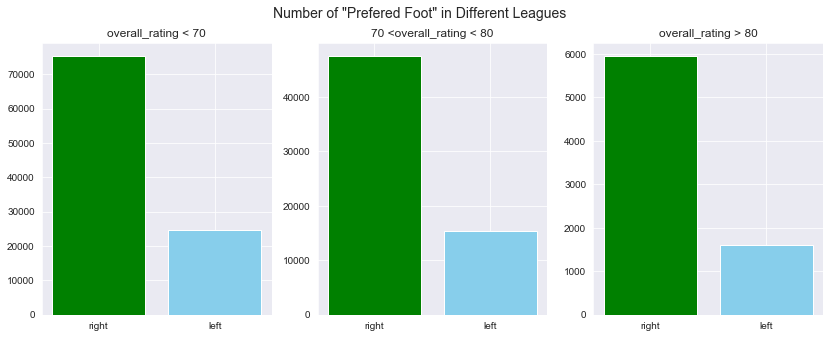

In [71]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (14,5))
ax1.bar(dfa[dfa['overall_rating'] <70]['preferred_foot'].value_counts().index, dfa[dfa['overall_rating'] <70]['preferred_foot'].value_counts(), color = ('green','skyblue'))
ax1.set_title('overall_rating < 70')
ax2.bar(dfa[(dfa['overall_rating'] <80) & (dfa['overall_rating'] >70)]['preferred_foot'].value_counts().index, dfa[(dfa['overall_rating'] <80) & (dfa['overall_rating'] >70)]['preferred_foot'].value_counts(), color = ('green','skyblue'))
ax2.set_title('70 <overall_rating < 80')
ax3.bar(dfa[dfa['overall_rating'] > 80]['preferred_foot'].value_counts().index, dfa[dfa['overall_rating']>80]['preferred_foot'].value_counts(), color = ('green','skyblue'))
ax3.set_title('overall_rating > 80')
fig.suptitle ('Number of "Prefered Foot" in Different Leagues', fontsize = 14)


>We need only four columns from this dataset: 
- **'date'**
- **'player_fifa_api_id'**, 
- **'player_api_id'** 
- **'overall_rating'**

>So, let's drop other columns.